* with callbacks
* "mentha", "murraya koenigii" and "syzygium_jambos" removed
* top-3 similarly looking leaves returned (modifications made in the last function of the last cell only)
* Grad-CAM / Grad-CAM++ block (top predicted class only)
* JSON DB

In [34]:
# Step 1: imports & environment check (run first)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout,
    Conv2D, Add, Multiply, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# avoids TensorFlow from grabbing all GPU memory upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# constants
BASE_PATH = '/kaggle/input/leaflookalike-dataset'   # keep your path
CLASSES = [
    "alpinia_galanga",
    "azadirachta_indica",
    "basella_alba",
    "jasminum",
    "nerium_oleander",
    "plectranthus_amboinicus",
    # "syzygium_jambos",
    "trigonella_foenum_graecum"
]
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = len(CLASSES)
AUTOTUNE = tf.data.AUTOTUNE

# modality folders (as you used)
RGB_ROOT = os.path.join(BASE_PATH, 'rgb')
VEIN_ROOT = os.path.join(BASE_PATH, 'vein')
TEX_ROOT = os.path.join(BASE_PATH, 'texture')

# quick sanity
assert os.path.exists(BASE_PATH), f"Base path not found: {BASE_PATH}"
print("Found base path, proceeding.")
print(NUM_CLASSES)

TF version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found base path, proceeding.
7


In [35]:
# Step 2: collect file lists for train/validate ensuring matching filenames across modalities.
def make_stem_map(folder):
    # returns dict: stem -> fullpath
    files = {}
    if not os.path.isdir(folder):
        return files
    for fname in os.listdir(folder):
        if fname.startswith('.'): 
            continue
        stem = os.path.splitext(fname)[0]
        files[stem] = os.path.join(folder, fname)
    return files

def collect_paths_for_split(split='train'):
    rgb_list, vein_list, tex_list, labels = [], [], [], []
    for idx, cls in enumerate(CLASSES):
        rgb_dir = os.path.join(RGB_ROOT, split, cls)
        vein_dir = os.path.join(VEIN_ROOT, split, cls)
        tex_dir = os.path.join(TEX_ROOT, split, cls)

        # build stem->file maps
        rgb_map = make_stem_map(rgb_dir)
        vein_map = make_stem_map(vein_dir)
        tex_map = make_stem_map(tex_dir)

        # iterate stems in rgb_map and keep only ones present in all three maps
        for stem, rgb_path in sorted(rgb_map.items()):
            v = vein_map.get(stem)
            t = tex_map.get(stem)
            if v and t:
                rgb_list.append(rgb_path)
                vein_list.append(v)
                tex_list.append(t)
                labels.append(idx)
        print(f"{split}/{cls}: matched {sum(1 for s in rgb_map if s in vein_map and s in tex_map)} files")

    print(f"Total {split} samples: {len(labels)}")
    return rgb_list, vein_list, tex_list, labels

# Run for train and validate
rgb_train, vein_train, tex_train, y_train = collect_paths_for_split('train')
rgb_val, vein_val, tex_val, y_val = collect_paths_for_split('validate')

train/alpinia_galanga: matched 1664 files
train/azadirachta_indica: matched 1712 files
train/basella_alba: matched 1856 files
train/jasminum: matched 1648 files
train/nerium_oleander: matched 1152 files
train/plectranthus_amboinicus: matched 2240 files
train/trigonella_foenum_graecum: matched 1600 files
Total train samples: 11872
validate/alpinia_galanga: matched 23 files
validate/azadirachta_indica: matched 24 files
validate/basella_alba: matched 26 files
validate/jasminum: matched 22 files
validate/nerium_oleander: matched 16 files
validate/plectranthus_amboinicus: matched 28 files
validate/trigonella_foenum_graecum: matched 22 files
Total validate samples: 161


In [36]:
# Step 3: dataset pipeline (decoding, resize, preprocess_input for MobileNetV3)
IMG_H, IMG_W = IMG_SIZE

def load_and_preprocess(rgb_path, vein_path, tex_path, label, is_train=False):
    # read files
    rgb = tf.io.read_file(rgb_path)
    vein = tf.io.read_file(vein_path)
    tex = tf.io.read_file(tex_path)

    # decode (rgb 3 channel, vein/tex as single channel)
    rgb = tf.image.decode_jpeg(rgb, channels=3)
    vein = tf.image.decode_jpeg(vein, channels=1)
    tex  = tf.image.decode_jpeg(tex, channels=1)

    # resize
    rgb = tf.image.resize(rgb, [IMG_H, IMG_W])
    vein = tf.image.resize(vein, [IMG_H, IMG_W])
    tex  = tf.image.resize(tex,  [IMG_H, IMG_W])

    # cast to float32
    rgb = tf.cast(rgb, tf.float32)
    vein = tf.cast(vein, tf.float32)
    tex  = tf.cast(tex, tf.float32)

    # optional simple augmentations (only for training)
    if is_train:
        # random horizontal flip
        flip = tf.random.uniform([]) > 0.5
        if flip:
            rgb = tf.image.flip_left_right(rgb)
            vein = tf.image.flip_left_right(vein)
            tex  = tf.image.flip_left_right(tex)
        # small random brightness on rgb (example)
        rgb = tf.image.random_brightness(rgb, max_delta=0.05)

    # convert single-channel to 3-channel (duplicate) so MobileNetV3 accepts it
    vein = tf.image.grayscale_to_rgb(tf.cast(vein, tf.uint8))  # convert to uint8 then to rgb duplicating channel
    tex  = tf.image.grayscale_to_rgb(tf.cast(tex,  tf.uint8))

    # note: preprocess_input expects float32; we already cast rgb to float32, convert vein/tex back
    rgb = preprocess_input(rgb)
    vein = preprocess_input(tf.cast(vein, tf.float32))
    tex  = preprocess_input(tf.cast(tex,  tf.float32))

    label_onehot = tf.one_hot(label, depth=NUM_CLASSES)

    return (rgb, vein, tex), label_onehot

def create_dataset(rgb_paths, vein_paths, tex_paths, labels, is_train=True):
    ds = tf.data.Dataset.from_tensor_slices((rgb_paths, vein_paths, tex_paths, labels))
    # wrapper to pass is_train flag
    ds = ds.map(lambda r,v,t,l: load_and_preprocess(r,v,t,l, is_train),
                num_parallel_calls=AUTOTUNE)
    if is_train:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

# create datasets
train_ds = create_dataset(rgb_train, vein_train, tex_train, y_train, is_train=True)
val_ds   = create_dataset(rgb_val, vein_val, tex_val, y_val, is_train=False)

# quick shape check (take one batch)
for (r,v,t), y in train_ds.take(1):
    print("Batch shapes -> rgb:", r.shape, "vein:", v.shape, "tex:", t.shape, "labels:", y.shape)

Batch shapes -> rgb: (16, 224, 224, 3) vein: (16, 224, 224, 3) tex: (16, 224, 224, 3) labels: (16, 7)


In [37]:
# ------------------------
# 1. ECA
# ------------------------
class ECA(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECA, self).__init__(**kwargs)
        self.k_size = k_size

    def build(self, input_shape):
        # conv over channel dimension after reshaping to (B, C, 1, 1)
        self.conv = Conv2D(1, kernel_size=(self.k_size, 1), padding="same", use_bias=False)

    def call(self, x):
        y = tf.reduce_mean(x, axis=[1, 2], keepdims=True)  # (B,1,1,C)
        y = tf.transpose(y, [0, 3, 1, 2])                  # (B,C,1,1)
        y = self.conv(y)
        y = tf.transpose(y, [0, 2, 3, 1])                  # (B,1,1,C)
        y = tf.sigmoid(y)
        return x * y

# ------------------------
# 2. Spatial Attention
# ------------------------
class SpatialAttention(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.conv = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")

    def call(self, x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attn = self.conv(concat)
        return x * attn

# ------------------------
# 3. Graph-safe MobileViTBlock (patch_h/patch_w set to 1 to avoid padding logic)
# ------------------------
class MobileViTBlock(tf.keras.layers.Layer):
    def __init__(self, num_heads=2, projection_dim=64, patch_h=1, patch_w=1, **kwargs):
        super(MobileViTBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.patch_h = patch_h
        self.patch_w = patch_w

    def build(self, input_shape):
        # input_shape: (B, H, W, C_in)
        _, H, W, C_in = input_shape
        # 1x1 conv to reduce channels to projection_dim
        self.proj_conv = Conv2D(self.projection_dim, kernel_size=1, padding="same", activation="relu")
        self.norm = LayerNormalization(epsilon=1e-6)
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.projection_dim)
        self.ffn = tf.keras.Sequential([
            Dense(self.projection_dim * 2, activation="relu"),
            Dense(self.projection_dim)
        ])
        # token mapping layers
        self.to_tokens = Dense(self.projection_dim)
        self.to_patches = Dense(self.projection_dim)
        # final projection back to projection_dim channels
        self.proj_back = Conv2D(self.projection_dim, kernel_size=1, padding="same")

        super(MobileViTBlock, self).build(input_shape)

    def call(self, x):
        # Project channels
        y = self.proj_conv(x)  # (B,H,W,proj_dim)
        shape = tf.shape(y)
        b = shape[0]; h = shape[1]; w = shape[2]; c = shape[3]

        # Flatten spatial dimension for token processing (B, H*W, C)
        y_flat = tf.reshape(y, [b, h * w, c])

        # Map to token dim used by MHA
        y_tokens = self.to_tokens(y_flat)           # (B, N, proj_dim)
        y_norm = self.norm(y_tokens)
        attn = self.mha(y_norm, y_norm)             # (B, N, proj_dim)
        y_tokens = y_tokens + attn
        y_tokens = y_tokens + self.ffn(y_tokens)

        # Map tokens back to spatial embeddings and reshape to H,W
        y_out = self.to_patches(y_tokens)           # (B, N, proj_dim)
        y_out = tf.reshape(y_out, [b, h, w, c])     # (B, H, W, proj_dim)
        y_out = self.proj_back(y_out)               # (B, H, W, proj_dim)

        return y_out

# ------------------------
# 4. Mid-fusion model (returns only main_out so train_ds/val_ds work unchanged)
# ------------------------
def build_midfusion_model(num_classes=NUM_CLASSES, freeze_backbone=True,
                          use_mobilevit=True, projection_dim=128):
    from tensorflow.keras.applications import MobileNetV3Large

    input_rgb = Input(shape=(224, 224, 3), name="rgb_input")
    input_vein = Input(shape=(224, 224, 3), name="vein_input")
    input_tex = Input(shape=(224, 224, 3), name="tex_input")

    # Shared MobileNetV3Large backbone (weights shared across modalities)
    backbone = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    backbone.trainable = not freeze_backbone

    # Extract feature maps for each modality using shared backbone (weight sharing)
    f_rgb = backbone(input_rgb)   # e.g., (B,7,7,960)
    f_vein = backbone(input_vein)
    f_tex = backbone(input_tex)

    # Reduce channels to projection_dim to keep MobileViT blocks efficient
    reduce_conv = lambda name: Conv2D(projection_dim, 1, padding="same", activation="relu", name=name)
    r_rgb = reduce_conv("reduce_rgb")(f_rgb)
    r_vein = reduce_conv("reduce_vein")(f_vein)
    r_tex = reduce_conv("reduce_tex")(f_tex)

    # Per-modality attention
    r_rgb = ECA()(r_rgb); r_rgb = SpatialAttention()(r_rgb)
    r_vein = ECA()(r_vein); r_vein = SpatialAttention()(r_vein)
    r_tex = ECA()(r_tex); r_tex = SpatialAttention()(r_tex)

    # Optional per-modality MobileViT refinement
    if use_mobilevit:
        # with small spatial dims from backbone (7x7), patch_h=1 keeps things robust
        r_rgb = MobileViTBlock(num_heads=2, projection_dim=projection_dim)(r_rgb)
        r_vein = MobileViTBlock(num_heads=2, projection_dim=projection_dim)(r_vein)
        r_tex = MobileViTBlock(num_heads=2, projection_dim=projection_dim)(r_tex)

    # ----- MID-FUSION (spatial) -----
    fused = Concatenate(axis=-1)([r_rgb, r_vein, r_tex])   # channels = 3 * projection_dim
    fused = Conv2D(projection_dim, kernel_size=1, padding="same", activation="relu", name="fused_reduce")(fused)

    if use_mobilevit:
        fused = MobileViTBlock(num_heads=4, projection_dim=projection_dim)(fused)

    # Global pooled fused representation -> main classifier
    g_fused = GlobalAveragePooling2D()(fused)
    x = Dense(512, activation="relu")(g_fused)
    x = Dropout(0.4)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    main_out = Dense(num_classes, activation="softmax", name="main_out")(x)

    # ---- Auxiliary heads created but NOT returned as model outputs ----
    # (This keeps them available for later use, but they don't affect fit() since model
    #  returns only the main_out.)
    g_rgb = GlobalAveragePooling2D()(r_rgb)
    g_vein = GlobalAveragePooling2D()(r_vein)
    g_tex = GlobalAveragePooling2D()(r_tex)
    aux_rgb_internal = Dense(num_classes, activation="softmax", name="aux_rgb_internal")(g_rgb)
    aux_vt_internal = Dense(num_classes, activation="softmax", name="aux_vt_internal")(Concatenate()([g_vein, g_tex]))
    # Note: these layers exist in the graph but are not part of Model.outputs

    model = Model(inputs=[input_rgb, input_vein, input_tex],
                  outputs=[main_out], name="MidFusion_MainOnly")

    return model

# ------------------------
# Prevent old models from piling up in GPU memory
# ------------------------
from tensorflow.keras import backend as K
import gc

K.clear_session()
gc.collect()

# ------------------------
# Build and compile (single-output model)
# ------------------------
model = build_midfusion_model(num_classes=NUM_CLASSES, freeze_backbone=True, use_mobilevit=True, projection_dim=128)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "MidFusion_MainOnly"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vein_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tex_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Large    │ (None, 7, 7, 960) │  2,996,352 │ rgb_input[0][0],  │
│ (Functional)        │                   │            │ vein_input[0][0], │
│                     │                   │            │ tex_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_rgb (Conv2D) │ (None, 7, 7, 128) │    123,008 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_vein         │ (None, 7, 7, 128) │    123,008 │ MobileNetV3Large… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_tex (Conv2D) │ (None, 7, 7, 128) │    123,008 │ MobileNetV3Large… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eca (ECA)           │ (None, 7, 7, 128) │          3 │ reduce_rgb[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eca_1 (ECA)         │ (None, 7, 7, 128) │          3 │ reduce_vein[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eca_2 (ECA)         │ (None, 7, 7, 128) │          3 │ reduce_tex[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention   │ (None, 7, 7, 128) │         99 │ eca[0][0]         │
│ (SpatialAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention_1 │ (None, 7, 7, 128) │         99 │ eca_1[0][0]       │
│ (SpatialAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_attention_2 │ (None, 7, 7, 128) │         99 │ eca_2[0][0]       │
│ (SpatialAttention)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobile_vi_t_block   │ (None, 7, 7, 128) │    264,192 │ spatial_attentio… │
│ (MobileViTBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobile_vi_t_block_1 │ (None, 7, 7, 128) │    264,192 │ spatial_attentio… │
│ (MobileViTBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobile_vi_t_block_2 │ (None, 7, 7, 128) │    264,192 │ spatial_attentio… │
│ (MobileViTBlock)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 384) │          0 │ mobile_vi_t_bloc… │
│ (Concatenate)       │                   │            │ mobile_vi_t_bloc… │
│                     │                   │            │ mobile_vi_t_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fused_reduce        │ (None, 7, 7, 128) │     49,280 │ concatenate[0][0

 Total params: 4,802,745 (18.32 MB)

 Trainable params: 1,806,393 (6.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [38]:
# ------------------------
# Step 5: Training (with callbacks based on accuracy)
# ------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 50

# Callback 1: Save the best model based on val_accuracy
checkpoint_cb = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

# Callback 2: Stop training early if val_accuracy doesn't improve
earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

# Callback 3: Reduce learning rate if val_accuracy plateaus
reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.5,               # reduce LR by half
    patience=5,               # wait 3 epochs before reducing
    min_lr=1e-6,
    mode="max",
    verbose=1
)

# Combine all callbacks
callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8975 - loss: 0.3371
Epoch 1: val_accuracy improved from -inf to 0.78882, saving model to best_model.keras
742/742 ━━━━━━━━━━━━━━━━━━━━ 114s 69ms/step - accuracy: 0.8975 - loss: 0.3370 - val_accuracy: 0.7888 - val_loss: 0.6195 - learning_rate: 1.0000e-04
Epoch 2/50
741/742 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9738 - loss: 0.0905
Epoch 2: val_accuracy improved from 0.78882 to 0.85093, saving model to best_model.keras
742/742 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.9738 - loss: 0.0904 - val_accuracy: 0.8509 - val_loss: 0.7675 - learning_rate: 1.0000e-04
Epoch 3/50
742/742 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9878 - loss: 0.0385
Epoch 3: val_accuracy improved from 0.85093 to 0.87578, saving model to best_model.keras
742/742 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - accuracy: 0.9878 - loss: 0.0385 - val_accuracy: 0.8758 - val_loss: 0.7509 - learning_rate: 1.0000e-04
Epoch 4/50
741/742 ━━━━━━━━━━━━━━

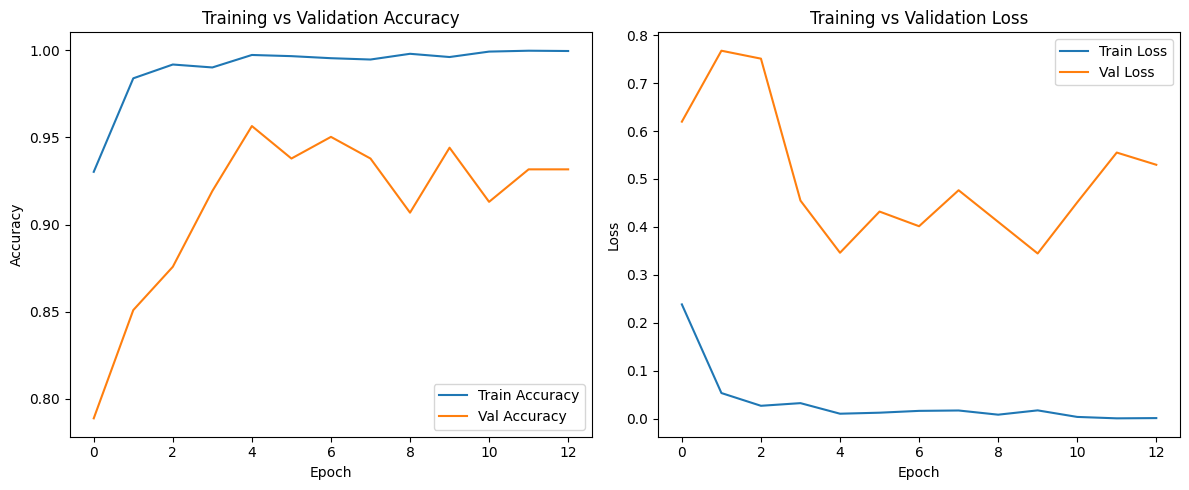


Classification Report:
                           precision    recall  f1-score   support

          alpinia_galanga       0.96      0.96      0.96        23
       azadirachta_indica       1.00      1.00      1.00        24
             basella_alba       1.00      1.00      1.00        26
                 jasminum       0.91      0.91      0.91        22
          nerium_oleander       0.94      0.94      0.94        16
  plectranthus_amboinicus       0.93      1.00      0.97        28
trigonella_foenum_graecum       0.95      0.86      0.90        22

                 accuracy                           0.96       161
                macro avg       0.96      0.95      0.95       161
             weighted avg       0.96      0.96      0.96       161



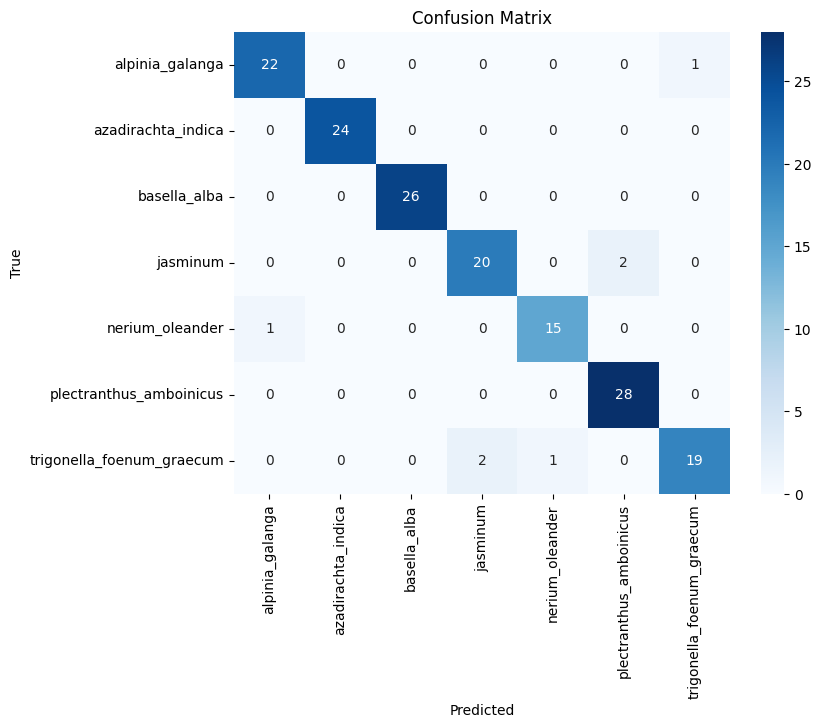


Accuracy (macro): 0.9565
Precision (macro): 0.9552
Recall (macro):    0.9524
F1 Score (macro):  0.9533


In [39]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model_full(model, dataset, class_names, top_k=3, print_samples=False):
    y_true_all, y_pred_all = [], []

    for step, (X_batch, y_true_batch) in enumerate(dataset):
        # Convert ground truth to numeric labels
        y_true = tf.argmax(y_true_batch, axis=1).numpy()

        # Predict once per batch (no verbose)
        y_pred_probs = model.predict(X_batch, verbose=0)

        # Compute top-k indices and probabilities (vectorized)
        top3_idx = np.argpartition(y_pred_probs, -top_k, axis=1)[:, -top_k:]
        sorted_order = np.argsort(y_pred_probs[np.arange(len(y_pred_probs))[:, None], top3_idx], axis=1)[:, ::-1]
        top3_idx = np.take_along_axis(top3_idx, sorted_order, axis=1)
        top3_conf = np.take_along_axis(y_pred_probs, top3_idx, axis=1)

        # Top-1 prediction for metrics
        y_pred = top3_idx[:, 0]

        # Print first few samples (optional)
        if print_samples and step == 0:
            for i in range(min(3, len(y_true))):
                print(f"\nSample {i+1}: True = {class_names[y_true[i]]}")
                for rank in range(top_k):
                    cls_name = class_names[top3_idx[i, rank]]
                    conf = top3_conf[i, rank]
                    print(f"   Top-{rank+1}: {cls_name} ({conf*100:.2f}%)")

        y_true_all.append(y_true)
        y_pred_all.append(y_pred)

    # Concatenate results instead of extending lists
    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    # Metrics
    print("\nClassification Report:")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names))

    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_true_all, y_pred_all)
    precision = precision_score(y_true_all, y_pred_all, average='macro')
    recall = recall_score(y_true_all, y_pred_all, average='macro')
    f1 = f1_score(y_true_all, y_pred_all, average='macro')
    print(f"\nAccuracy (macro): {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro):    {recall:.4f}")
    print(f"F1 Score (macro):  {f1:.4f}")

# Plot
plot_training_history(history)
# Evaluate on validation set
evaluate_model_full(model, val_ds, class_names=CLASSES)


Sample 1: True = alpinia_galanga
   Top-1: alpinia_galanga (99.92%)
   Top-2: trigonella_foenum_graecum (0.04%)
   Top-3: nerium_oleander (0.04%)

Sample 2: True = alpinia_galanga
   Top-1: alpinia_galanga (99.95%)
   Top-2: trigonella_foenum_graecum (0.02%)
   Top-3: nerium_oleander (0.02%)

Sample 3: True = alpinia_galanga
   Top-1: alpinia_galanga (99.98%)
   Top-2: nerium_oleander (0.01%)
   Top-3: plectranthus_amboinicus (0.01%)

Classification Report:
                           precision    recall  f1-score   support

          alpinia_galanga       0.96      0.96      0.96        23
       azadirachta_indica       1.00      1.00      1.00        24
             basella_alba       1.00      1.00      1.00        26
                 jasminum       0.91      0.91      0.91        22
          nerium_oleander       0.94      0.94      0.94        16
  plectranthus_amboinicus       0.93      1.00      0.97        28
trigonella_foenum_graecum       0.95      0.86      0.90        22


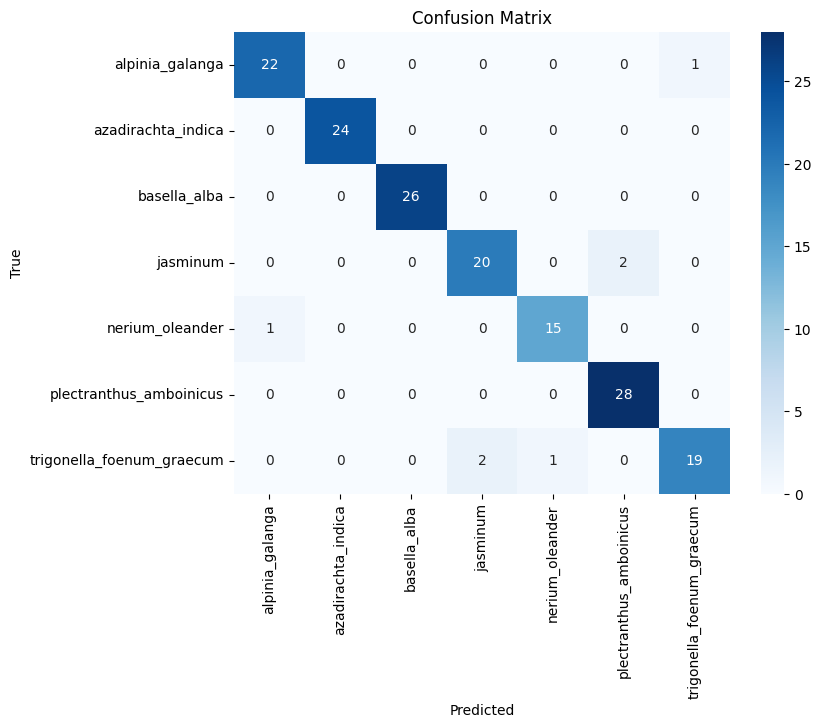


Accuracy (macro): 0.9565
Precision (macro): 0.9552
Recall (macro):    0.9524
F1 Score (macro):  0.9533


In [40]:
evaluate_model_full(model, val_ds, class_names=CLASSES, print_samples=True)

In [41]:
# ===============================
# Cell 8: Grad-CAM / Grad-CAM++
# ===============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_gradcam_heatmap(model, img_inputs, layer_name, class_index=None, use_gradcam_plus_plus=False):
    """
    Generates Grad-CAM or Grad-CAM++ heatmap for a multimodal model.
    - img_inputs: list of input arrays [rgb, vein, tex], each shaped (1, H, W, 3)
    - layer_name: name of the last convolutional layer (string)
    - class_index: target class index (int)
    - use_gradcam_plus_plus: True for Grad-CAM++
    """
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_inputs)
        predictions = predictions if isinstance(predictions, tf.Tensor) else predictions[0]
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        output = predictions[:, class_index]

    grads = tape.gradient(output, conv_outputs)

    if use_gradcam_plus_plus:
        # --- Grad-CAM++ variant ---
        grads_power_2 = tf.pow(grads, 2)
        grads_power_3 = tf.pow(grads, 3)
        sum_grads = tf.reduce_sum(conv_outputs * grads_power_3, axis=(1, 2))

        # Ensure shape compatibility for broadcasting
        sum_grads = tf.reshape(sum_grads, [tf.shape(sum_grads)[0], 1, 1, tf.shape(sum_grads)[-1]])

        eps = 1e-8
        alpha_num = grads_power_2
        alpha_denom = 2 * grads_power_2 + sum_grads
        alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, eps)
        alphas = alpha_num / alpha_denom
        weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))

    else:
        # --- Standard Grad-CAM ---
        weights = tf.reduce_mean(grads, axis=(1, 2))

    cam = tf.reduce_sum(tf.multiply(weights[:, tf.newaxis, tf.newaxis, :], conv_outputs), axis=-1)
    heatmap = tf.nn.relu(cam)
    heatmap = heatmap / tf.reduce_max(heatmap)
    heatmap = heatmap[0].numpy()

    return heatmap


def display_gradcam(model, rgb_img_path, class_names, layer_name="fused_reduce", use_gradcam_plus_plus=False):
    """
    Displays Grad-CAM heatmap overlay for one image (RGB modality only)
    """
    # Load and preprocess image
    img = tf.io.read_file(rgb_img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, [224, 224])
    img_pre = preprocess_input(tf.cast(img_resized, tf.float32))
    img_array = tf.expand_dims(img_pre, axis=0)  # (1,224,224,3)

    # Run model to get predicted class
    preds = model.predict([img_array, img_array, img_array], verbose=0)
    preds = preds if isinstance(preds, np.ndarray) else preds[0]
    pred_index = np.argmax(preds[0])
    pred_label = class_names[pred_index]
    pred_conf = preds[0][pred_index]

    # Generate Grad-CAM
    heatmap = get_gradcam_heatmap(model, [img_array, img_array, img_array], layer_name, pred_index, use_gradcam_plus_plus)

    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(img.numpy(), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(f"Original Image\nPredicted: {pred_label} ({pred_conf*100:.2f}%)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM {'++' if use_gradcam_plus_plus else ''}")
    plt.axis("off")
    plt.show()

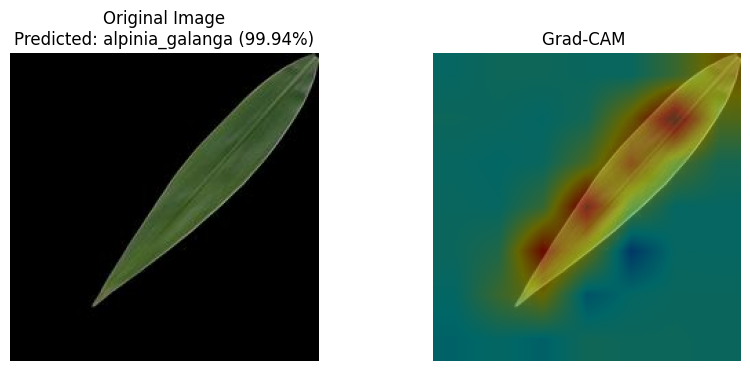

In [42]:
# ===============================
# Cell 9: Grad-CAM Demo
# ===============================
sample_rgb = rgb_val[6]  # change index to test other images

display_gradcam(
    model,
    rgb_img_path=sample_rgb,
    class_names=CLASSES,
    layer_name="fused_reduce",
    use_gradcam_plus_plus=False   # change to True for Grad-CAM++
)

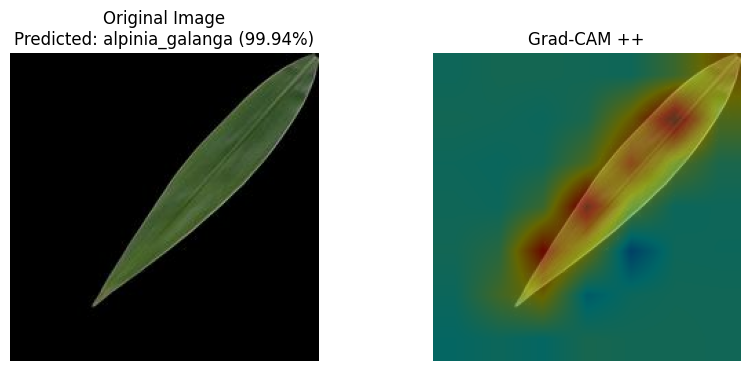

In [43]:
# ===============================
# Cell 9: Grad-CAM++ Demo
# ===============================
sample_rgb = rgb_val[6]  # change index to test other images

display_gradcam(
    model,
    rgb_img_path=sample_rgb,
    class_names=CLASSES,
    layer_name="fused_reduce",
    use_gradcam_plus_plus=True   # change to True for Grad-CAM++
)

In [44]:
# ===============================
# Cell 11: Load the JSON file
# ===============================
import json

# Path to your uploaded JSON file
KNOWLEDGE_DB_PATH = '/kaggle/input/medicinal-leaves-knowledge-db/knowledge_db.json'

# Load the JSON
with open(KNOWLEDGE_DB_PATH, 'r') as f:
    knowledge_db = json.load(f)

In [45]:
# ===============================
# Cell 12: Function to fetch plant info
# ===============================
def get_plant_info(plant_name):
    """Fetch info from the knowledge DB for the given class name."""
    if plant_name in knowledge_db:
        info = knowledge_db[plant_name]
        display_info = f"""
📖 **Scientific Name:** {info.get("Scientific Name", "N/A")}

🌿 **Medicinal Uses:**
- {chr(10).join(info.get("Medicinal Uses", []))}

🧪 **Active Compounds:**
- {chr(10).join(info.get("Active Compounds", []))}

⚠️ **Precautions:**
{info.get("Precautions", "N/A")}

🔗 **Sources:**
- {chr(10).join(info.get("Sources", []))}
"""
    else:
        display_info = f"No data found for {plant_name}"
    return display_info

In [46]:
# ===============================
# Cell 13: JSON DB Demo
# ===============================
# pred_label = CLASSES[np.argmax(pred_probs)]  # Example: "jasminum"
pred_label = "jasminum"
print("Predicted Leaf:", pred_label)

info_text = get_plant_info(pred_label)
print(info_text)

Predicted Leaf: jasminum

📖 **Scientific Name:** Jasminum sambac

🌿 **Medicinal Uses:**
- Aromatherapeutic uses (stress relief, calming)
Used in traditional medicine for skin diseases, wounds
Used as anti‑inflammatory agent in folk remedies
Used in postpartum care, fever, digestive upset (in regional systems)

🧪 **Active Compounds:**
- Jasminoids, jasmine lactones
Flavonoids
Triterpenes
Essential oils (linalool, benzyl acetate, eugenol, etc.)

⚠️ **Precautions:**
May cause skin sensitivity / irritation in some individuals; avoid internal medicinal use in high doses without evidence; pregnancy & lactation safety unclear.

🔗 **Sources:**
- Ethnobotanical reviews on jasmine (Jasminum sambac)
Phytochemistry studies on jasmine flowers / leaves



In [47]:
# ===============================
# Cell 14: Create SQLite DB and table schema
# ===============================
# Cell A: imports & paths
import sqlite3
import json
import pandas as pd
import os

JSON_PATH = "/kaggle/input/medicinal-leaves-knowledge-db/knowledge_db.json"
SQLITE_PATH = "/kaggle/working/knowledge.db"   # this is where the DB file will be created
print("JSON exists:", os.path.exists(JSON_PATH))
print("SQLite target:", SQLITE_PATH)

# Cell B: create database and table
conn = sqlite3.connect(SQLITE_PATH)
cur = conn.cursor()

# Create a table. medicinal_uses and active_compounds stored as JSON text to keep structure.
cur.execute('''
CREATE TABLE IF NOT EXISTS leaf_knowledge (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    leaf_name TEXT UNIQUE NOT NULL,
    scientific_name TEXT,
    sources TEXT,
    medicinal_uses TEXT,
    active_compounds TEXT,
    precautions TEXT
)
''')
conn.commit()
conn.close()

print("DB created and table ensured.")

JSON exists: True
SQLite target: /kaggle/working/knowledge.db
DB created and table ensured.


In [48]:
# ===============================
# Cell 15: Load JSON and inspect keys (sanity check)
# ===============================
# Cell C: load your JSON and print available keys
with open(JSON_PATH, 'r') as f:
    kb = json.load(f)

print("Number of entries in JSON:", len(kb))
print("Example keys (leaf names):", list(kb.keys())[:8])

# Inspect one entry (pretty print)
import pprint
pprint.pprint(kb[list(kb.keys())[0]])

Number of entries in JSON: 8
Example keys (leaf names): ['alpinia_galanga', 'azadirachta_indica', 'basella_alba', 'jasminum', 'nerium_oleander', 'plectranthus_amboinicus', 'syzygium_jambos', 'trigonella_foenum_graecum']
{'Active Compounds': ['1′‑acetoxychavicol acetate (ACA)',
                      '1′‑acetoxyeugenol acetate',
                      'Galangin (a flavonol)',
                      'Methyl cinnamate',
                      '1,8‑cineole',
                      'α‑pinene, β‑pinene, β‑farnesene, '
                      'p‑hydroxycinnamaldehyde',
                      'Kaempferide, alpinine, other flavonoids, phenolics, '
                      'essential oils'],
 'Medicinal Uses': ['Digestive support (carminative, stomachic, improves '
                    'appetite)',
                    'Anti‑inflammatory, analgesic',
                    'Respiratory ailments: cough, bronchitis, throat '
                    'infections',
                    'Antimicrobial (antibacterial, anti

In [49]:
# ===============================
# Cell 16: Insert JSON rows into SQLite (safe, idempotent)
# ===============================
# Cell D: insert rows into sqlite, using parameterized queries
conn = sqlite3.connect(SQLITE_PATH)
cur = conn.cursor()

def to_json_text(obj):
    # convert Python list/dict to compact JSON string
    return json.dumps(obj, ensure_ascii=False)

insert_sql = '''
INSERT OR IGNORE INTO leaf_knowledge 
(leaf_name, scientific_name, sources, medicinal_uses, active_compounds, precautions)
VALUES (?, ?, ?, ?, ?, ?)
'''

for leaf_name, info in kb.items():
    sci = info.get("Scientific Name")
    sources = to_json_text(info.get("Sources", []))
    uses = to_json_text(info.get("Medicinal Uses", []))
    compounds = to_json_text(info.get("Active Compounds", []))
    precautions = info.get("Precautions", "")
    cur.execute(insert_sql, (leaf_name, sci, sources, uses, compounds, precautions))

conn.commit()
print("Inserted rows (or ignored if existed).")
conn.close()

Inserted rows (or ignored if existed).


In [50]:
# ===============================
# Cell 17: Query & verify contents (print table as DataFrame)
# ===============================
# Cell E: read table into pandas for verification
conn = sqlite3.connect(SQLITE_PATH)
df = pd.read_sql_query("SELECT id, leaf_name, scientific_name FROM leaf_knowledge ORDER BY leaf_name", conn)
conn.close()
print("Rows in DB:", len(df))
df.head(20)

Rows in DB: 8


,id,leaf_name,scientific_name
0,1,alpinia_galanga,Alpinia galanga
1,2,azadirachta_indica,Azadirachta indica
2,3,basella_alba,Basella alba
3,4,jasminum,Jasminum sambac
4,5,nerium_oleander,Nerium oleander
5,6,plectranthus_amboinicus,Plectranthus amboinicus
6,7,syzygium_jambos,Syzygium jambos
7,8,trigonella_foenum_graecum,Trigonella foenum-graecum


In [51]:
# ===============================
# Cell 18: SQLite DB Demo
# ===============================
def fetch_leaf_info_pretty(leaf_name):
    conn = sqlite3.connect(SQLITE_PATH)
    cur = conn.cursor()
    cur.execute("SELECT * FROM leaf_knowledge WHERE leaf_name=?", (leaf_name,))
    row = cur.fetchone()
    conn.close()
    
    if not row:
        print(f"No data found for {leaf_name}")
        return

    # Extract fields
    _, leaf_name, scientific_name, sources_json, uses_json, compounds_json, precautions = row
    sources = json.loads(sources_json) if sources_json else []
    medicinal_uses = json.loads(uses_json) if uses_json else []
    active_compounds = json.loads(compounds_json) if compounds_json else []

    # Format for pretty display
    print(f"Predicted Leaf: {leaf_name}\n")
    print(f"📖 **Scientific Name:** {scientific_name or 'N/A'}\n")
    
    print(f"🌿 **Medicinal Uses:**")
    for use in medicinal_uses:
        print(f"- {use}")
    print()

    print(f"🧪 **Active Compounds:**")
    for compound in active_compounds:
        print(f"- {compound}")
    print()

    print(f"⚠️ **Precautions:**")
    print(precautions or "N/A")
    print()

    print(f"🔗 **Sources:**")
    for source in sources:
        print(f"- {source}")

# Usage:
fetch_leaf_info_pretty("jasminum")

Predicted Leaf: jasminum

📖 **Scientific Name:** Jasminum sambac

🌿 **Medicinal Uses:**
- Aromatherapeutic uses (stress relief, calming)
- Used in traditional medicine for skin diseases, wounds
- Used as anti‑inflammatory agent in folk remedies
- Used in postpartum care, fever, digestive upset (in regional systems)

🧪 **Active Compounds:**
- Jasminoids, jasmine lactones
- Flavonoids
- Triterpenes
- Essential oils (linalool, benzyl acetate, eugenol, etc.)

⚠️ **Precautions:**
May cause skin sensitivity / irritation in some individuals; avoid internal medicinal use in high doses without evidence; pregnancy & lactation safety unclear.

🔗 **Sources:**
- Ethnobotanical reviews on jasmine (Jasminum sambac)
- Phytochemistry studies on jasmine flowers / leaves


TESTING OF MODEL!!!

In [52]:
# ===============================
# Cell 1: Paths and Class Names
# ===============================
import os

# Root of the uploaded dataset
ROOT_TEST_DIR = "/kaggle/input/leaflookalike-testing-dataset"

# Modalities
RGB_TEST_DIR   = os.path.join(ROOT_TEST_DIR, "bg_removed")
VEIN_TEST_DIR  = os.path.join(ROOT_TEST_DIR, "vein_enhancement")
TEX_TEST_DIR   = os.path.join(ROOT_TEST_DIR, "texture_enhancement")

# Class names (folders)
CLASSES = [
    "alpinia_galanga",
    "azadirachta_indica",
    "basella_alba",
    "jasminum",
    "nerium_oleander",
    "plectranthus_amboinicus",
    # "syzygium_jambos",
    "trigonella_foenum_graecum"
]

print("Directories ready.")

Directories ready.


In [53]:
# ===============================
# Cell 2: Create Test Dataset Loader
# ===============================
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

def create_dataset(rgb_dir, vein_dir, tex_dir, class_names):
    rgb_paths, vein_paths, tex_paths, labels = [], [], [], []

    for i, cls in enumerate(class_names):
        rgb_folder  = os.path.join(rgb_dir, cls)
        vein_folder = os.path.join(vein_dir, cls)
        tex_folder  = os.path.join(tex_dir, cls)

        for fname in os.listdir(rgb_folder):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                rgb_paths.append(os.path.join(rgb_folder, fname))
                vein_paths.append(os.path.join(vein_folder, fname))
                tex_paths.append(os.path.join(tex_folder, fname))
                labels.append(i)

    rgb_ds  = tf.data.Dataset.from_tensor_slices(rgb_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    vein_ds = tf.data.Dataset.from_tensor_slices(vein_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    tex_ds  = tf.data.Dataset.from_tensor_slices(tex_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.keras.utils.to_categorical(labels, num_classes=len(class_names)))

    ds = tf.data.Dataset.zip(((rgb_ds, vein_ds, tex_ds), label_ds))
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds, rgb_paths

# Create test dataset
test_ds, rgb_test_paths = create_dataset(RGB_TEST_DIR, VEIN_TEST_DIR, TEX_TEST_DIR, CLASSES)
print("Test dataset ready with", len(rgb_test_paths), "images.")

Test dataset ready with 155 images.



Sample 1: True = alpinia_galanga
   Top-1: alpinia_galanga (68.82%)
   Top-2: trigonella_foenum_graecum (24.20%)
   Top-3: plectranthus_amboinicus (3.53%)

Sample 2: True = alpinia_galanga
   Top-1: trigonella_foenum_graecum (43.73%)
   Top-2: nerium_oleander (37.78%)
   Top-3: alpinia_galanga (5.27%)

Sample 3: True = alpinia_galanga
   Top-1: alpinia_galanga (96.62%)
   Top-2: nerium_oleander (1.27%)
   Top-3: plectranthus_amboinicus (1.24%)

Classification Report:
                           precision    recall  f1-score   support

          alpinia_galanga       1.00      0.65      0.79        23
       azadirachta_indica       1.00      0.91      0.95        22
             basella_alba       1.00      0.88      0.94        25
                 jasminum       0.86      0.95      0.90        20
          nerium_oleander       0.82      0.93      0.87        15
  plectranthus_amboinicus       0.90      0.96      0.93        28
trigonella_foenum_graecum       0.76      1.00      0.86 

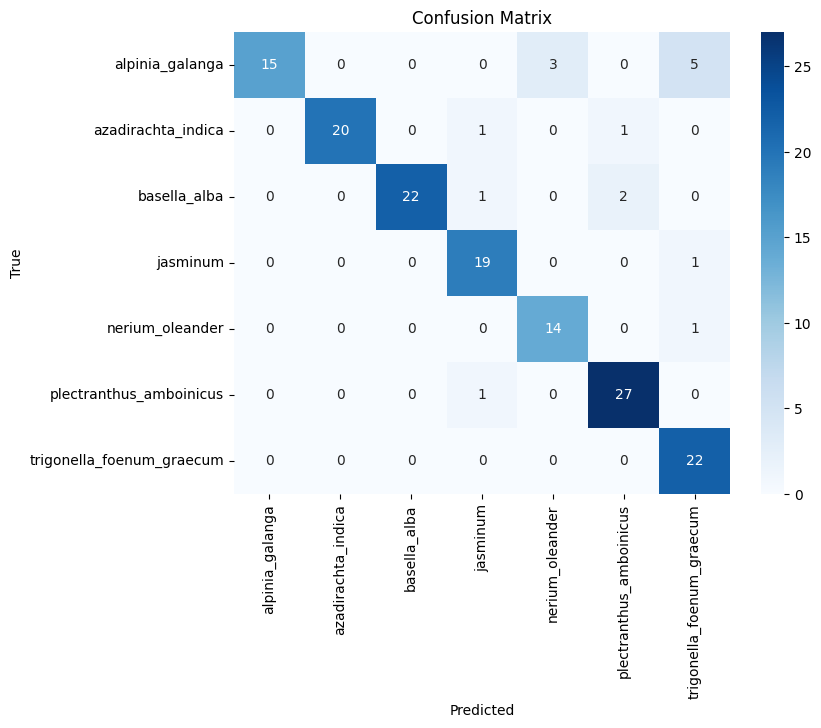


Accuracy (macro): 0.8968
Precision (macro): 0.9065
Recall (macro):    0.8984
F1 Score (macro):  0.8931


In [54]:
# ===============================
# Cell 3: Evaluate the Model
# ===============================
evaluate_model_full(model, test_ds, class_names=CLASSES, print_samples=True)

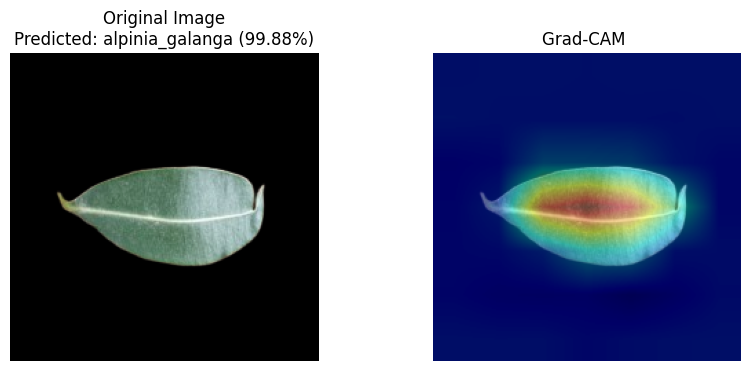

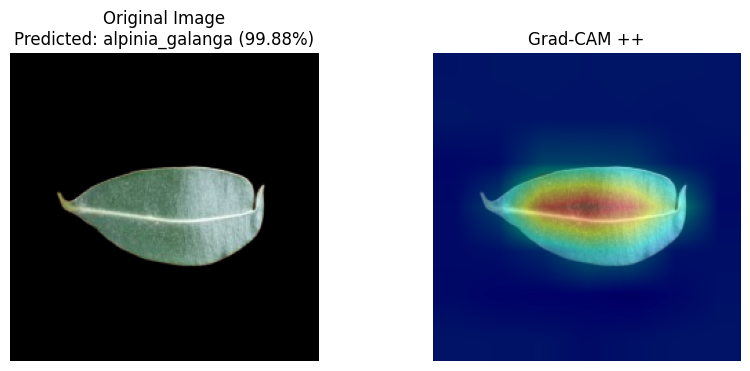

In [55]:
# ===============================
# Cell 4: Grad-CAM Visualization
# ===============================
# Pick a random test image to visualize
import random
idx = random.randint(0, len(rgb_test_paths)-1)
sample_rgb = rgb_test_paths[idx]

display_gradcam(
    model,
    rgb_img_path=sample_rgb,
    class_names=CLASSES,
    layer_name="fused_reduce",       # or your last conv layer name
    use_gradcam_plus_plus=False      # Standard Grad-CAM
)

# Grad-CAM++
display_gradcam(
    model,
    rgb_img_path=sample_rgb,
    class_names=CLASSES,
    layer_name="fused_reduce",
    use_gradcam_plus_plus=True       # Grad-CAM++
)

In [56]:
# ===============================
# Cell 5: Knowledge DB via JSON
# ===============================
# Suppose you got a prediction label
pred_label = "jasminum"  # Replace with the predicted class name
print("Fetching info for:", pred_label)
info_text = get_plant_info(pred_label)
print(info_text)

Fetching info for: jasminum

📖 **Scientific Name:** Jasminum sambac

🌿 **Medicinal Uses:**
- Aromatherapeutic uses (stress relief, calming)
Used in traditional medicine for skin diseases, wounds
Used as anti‑inflammatory agent in folk remedies
Used in postpartum care, fever, digestive upset (in regional systems)

🧪 **Active Compounds:**
- Jasminoids, jasmine lactones
Flavonoids
Triterpenes
Essential oils (linalool, benzyl acetate, eugenol, etc.)

⚠️ **Precautions:**
May cause skin sensitivity / irritation in some individuals; avoid internal medicinal use in high doses without evidence; pregnancy & lactation safety unclear.

🔗 **Sources:**
- Ethnobotanical reviews on jasmine (Jasminum sambac)
Phytochemistry studies on jasmine flowers / leaves



In [57]:
# ===============================
# Cell 6: Knowledge DB via SQLite
# ===============================
# Fetch and print same info from SQLite DB
fetch_leaf_info_pretty(pred_label)

Predicted Leaf: jasminum

📖 **Scientific Name:** Jasminum sambac

🌿 **Medicinal Uses:**
- Aromatherapeutic uses (stress relief, calming)
- Used in traditional medicine for skin diseases, wounds
- Used as anti‑inflammatory agent in folk remedies
- Used in postpartum care, fever, digestive upset (in regional systems)

🧪 **Active Compounds:**
- Jasminoids, jasmine lactones
- Flavonoids
- Triterpenes
- Essential oils (linalool, benzyl acetate, eugenol, etc.)

⚠️ **Precautions:**
May cause skin sensitivity / irritation in some individuals; avoid internal medicinal use in high doses without evidence; pregnancy & lactation safety unclear.

🔗 **Sources:**
- Ethnobotanical reviews on jasmine (Jasminum sambac)
- Phytochemistry studies on jasmine flowers / leaves
